____
### Learning Goals for This Tutorial

By the end of this tutorial you will:
* Understand what sentiment analysis is and how it works
* Read text from a dataset & tokenize it
* Use a sentiment lexicon to analyze the sentiment of texts
* Visualize the sentiment of texts

### Table of contents

* [Introduction](#Introduction)
* [Tutorial](#Tutorial)
* [Exercises](#Exercises)

**<center>Already a sentiment analysis pro? Challenge yourself by jumping straight to the exercises!</center>**
____

# Introduction

### What is sentiment analysis?

Sentiment analysis is the computational task of automatically determining what feelings a writer is expressing in text. Sentiment is often framed as a binary distinction (positive vs. negative), but it can also be a more fine-grained, like identifying the specific emotion an author is expressing (like fear, joy or anger).

Sentiment analysis is used for many applications, especially in business intelligence. Some examples of applications for sentiment analysis include:

* Analyzing the social media discussion around a certain topic
* Evaluating survey responses
* Determining whether product reviews are positive or negative

Sentiment analysis is not perfect, and as with any automatic analysis of language, you will have errors in your results. It also cannot tell you why a writer is feeling a certain way. However, it can be useful to quickly summarize some qualities of text, especially if you have so much text that a human reader cannot analyze all of it.

_______

### How does it work?
 
There are many ways to do sentiment analysis (if you're interested, you can see many of them [here](https://cse.google.com/cse?cx=011664571474657673452%3A4w9swzkcxiy&cof=FORID%3A0&q=sentiment+analysis#gsc.tab=0&gsc.q=sentiment%20analysis&gsc.page=1)). Many approches use the same general idea, however:

1. Create or find a list of words associated with strongly positive or negative sentiment.
2. Count the number of positive and negative words in the text.
3. Analyze the mix of positive to negative words. Many positive words and few negative words indicates positive sentiment, while many negative words and few positive words indicates negative sentiment.

The first step, creating or finding a word list (also called a lexicon), is generally the most time-consuming. While you can often use a lexicon that already exists, if your text is discussing a specific topic you may need to add to or modify it.

> "Sick" is an example of a word that can have positive or negative sentiment depending on what it's used to refer to. If you're discussing a pet store that sells a lot of sick animals, the sentiment is probably negative. On the other hand, if you're talking about a skateboarding instructor who taught you how to do a lot of sick flips, the sentiment is probably very positive.

# Tutorial

For this tutorial, we're going to analyze how the sentiment of the State of the Union address, which is a speech given by the President of the United States to a joint session of congress every year. I'm interested in seeing how sentiment has changed over time, from 1989 to 2017, and whether different presidents tend to have more negative or more positive sentiment. 

First, let's load in the libraries we'll use and our data.

In [1]:
# load in the libraries we'll need
library(tidyverse)
library(tidytext)
library(glue)
library(stringr)

# get a list of the files in the input directory
files <- list.files("../input")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse



Let's start with the first file. The first thing we need to do is tokenize it, or break it into individual words. You can learn more about tokenization by following [this tutorial](https://www.kaggle.com/rtatman/tokenization-tutorial).

In [2]:
# stick together the path to the file & 1st file name
fileName <- glue("../input/", files[1], sep = "")
# get rid of any sneaky trailing spaces
fileName <- trimws(fileName)

# read in the new file
fileText <- glue(read_file(fileName))
# remove any dollar signs (they're special characters in R)
fileText <- gsub("\\$", "", fileText) 

# tokenize
tokens <- data_frame(text = fileText) %>% unnest_tokens(word, text)

Now that we have a list of tokens, we need to compare them against a list of words with either positive or negative sentiment.

> A list of words associated with a specific sentiment is usually called a "sentiment lexicon".

Because we're using the tidytext package, we actually already have some of these lists. I'm going to be using the "bing" list, which was developed by [Bing Liu and co-authors](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html).

In [3]:
# get the sentiment from the first text: 
tokens %>%
  inner_join(get_sentiments("bing")) %>% # pull out only sentiment words
  count(sentiment) %>% # count the # of positive & negative words
  spread(sentiment, n, fill = 0) %>% # made data wide rather than narrow
  mutate(sentiment = positive - negative) # # of positive words - # of negative owrds

Joining, by = "word"


negative,positive,sentiment
117,240,123


So this text has 117 negative polarity words and 240 positive polarity words. This means that there are 123 more positive than negative words in this text.

Now that we know how to get the sentiment for a given text, let's write a function to do this more quickly and easily and then apply that function to every text in our dataset.

In [4]:
# write a function that takes the name of a file and returns the # of postive
# sentiment words, negative sentiment words, the difference & the normalized difference
GetSentiment <- function(file){
    # get the file
    fileName <- glue("../input/", file, sep = "")
    # get rid of any sneaky trailing spaces
    fileName <- trimws(fileName)

    # read in the new file
    fileText <- glue(read_file(fileName))
    # remove any dollar signs (they're special characters in R)
    fileText <- gsub("\\$", "", fileText) 

    # tokenize
    tokens <- data_frame(text = fileText) %>% unnest_tokens(word, text)

    # get the sentiment from the first text: 
    sentiment <- tokens %>%
      inner_join(get_sentiments("bing")) %>% # pull out only sentimen words
      count(sentiment) %>% # count the # of positive & negative words
      spread(sentiment, n, fill = 0) %>% # made data wide rather than narrow
      mutate(sentiment = positive - negative) %>% # # of positive words - # of negative owrds
      mutate(file = file) %>% # add the name of our file
      mutate(year = as.numeric(str_match(file, "\\d{4}"))) %>% # add the year
      mutate(president = str_match(file, "(.*?)_")[2]) # add president

    # return our sentiment dataframe
    return(sentiment)
}

# test: should return
# negative	positive	sentiment	file	year	president
# 117	240	123	Bush_1989.txt	1989	Bush
GetSentiment(files[1])

Joining, by = "word"


negative,positive,sentiment,file,year,president
117,240,123,Bush_1989.txt,1989,Bush


Now, let's apply our function over every file in our dataset. We'll also need to make sure we can tell the difference between the two presidents named "Bush": Bush and Bush Sr.

In [5]:
# file to put our output in
sentiments <- data_frame()

# get the sentiments for each file in our datset
for(i in files){
    sentiments <- rbind(sentiments, GetSentiment(i))
}

# disambiguate Bush Sr. and George W. Bush 
# correct president in applicable rows
bushSr <- sentiments %>% 
  filter(president == "Bush") %>% # get rows where the president is named "Bush"...
  filter(year < 2000) %>% # ...and the year is before 200
  mutate(president = "Bush Sr.") # and change "Bush" to "Bush Sr."

# remove incorrect rows
sentiments <- anti_join(sentiments, sentiments[sentiments$president == "Bush" & sentiments$year < 2000, ])

# add corrected rows to data_frame 
sentiments <- full_join(sentiments, bushSr)

# summerize the sentiment measures
summary(sentiments)

Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = c("negative", "positive", "sentiment", "file", "year", "president")
Joining, by = c("negative", "positive", "sentiment", "file", "year", "president")


    negative        positive       sentiment         file          
 Min.   : 49.0   Min.   :169.0   Min.   : 43.0   Length:29         
 1st Qu.:122.0   1st Qu.:240.0   1st Qu.:102.0   Class :character  
 Median :144.0   Median :289.0   Median :140.0   Mode  :character  
 Mean   :143.5   Mean   :280.4   Mean   :136.9                     
 3rd Qu.:161.0   3rd Qu.:310.0   3rd Qu.:171.0                     
 Max.   :223.0   Max.   :438.0   Max.   :277.0                     
      year       president        
 Min.   :1989   Length:29         
 1st Qu.:1996   Class :character  
 Median :2003   Mode  :character  
 Mean   :2003                     
 3rd Qu.:2010                     
 Max.   :2017                     

It looks like every State of the Union address in this dataset has an overall positive sentiment (according to this measure). This isn't very surprising: most text, especially formal text, tends to have a positive skew.

Let's plot our sentiment analysis scores to see if we can notice any other patterns. Has sentiment changed over time? What about between presidents?

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


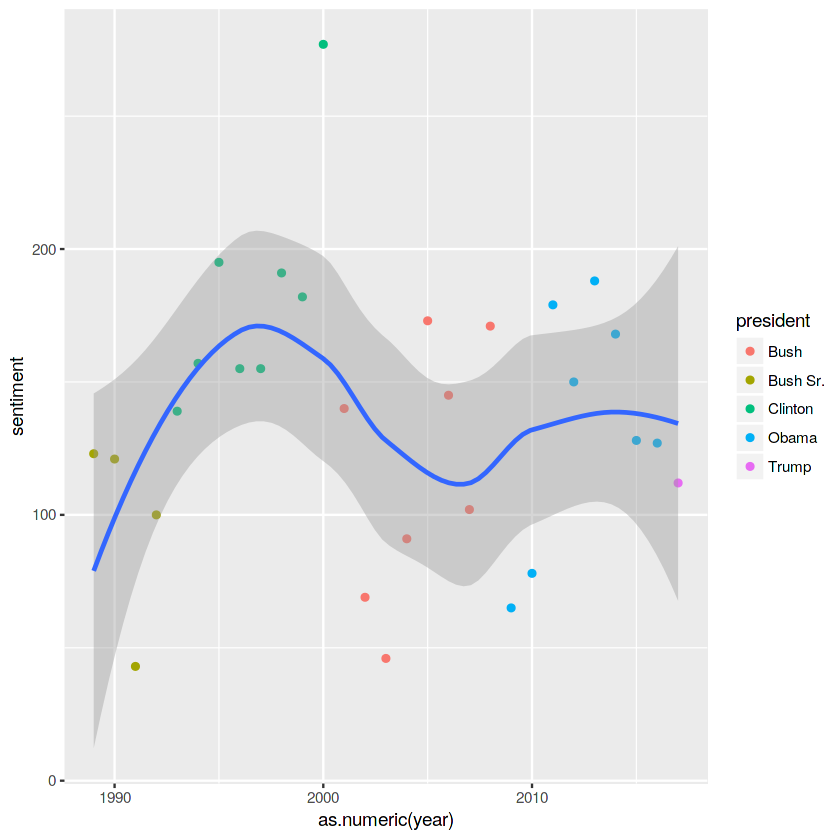

In [6]:
# plot of sentiment over time & automatically choose a method to model the change
ggplot(sentiments, aes(x = as.numeric(year), y = sentiment)) + 
  geom_point(aes(color = president))+ # add points to our plot, color-coded by president
  geom_smooth(method = "auto") # pick a method & fit a model

While it looks like there haven't been any strong trends over time, the line above suggests that presidents from the Democratic party (Clinton and Obama) have a slightly more positive sentiment than presidents from the Republican party (Bush Sr., Bush and Trump).  Let's look at individual presidents and see if that pattern holds:

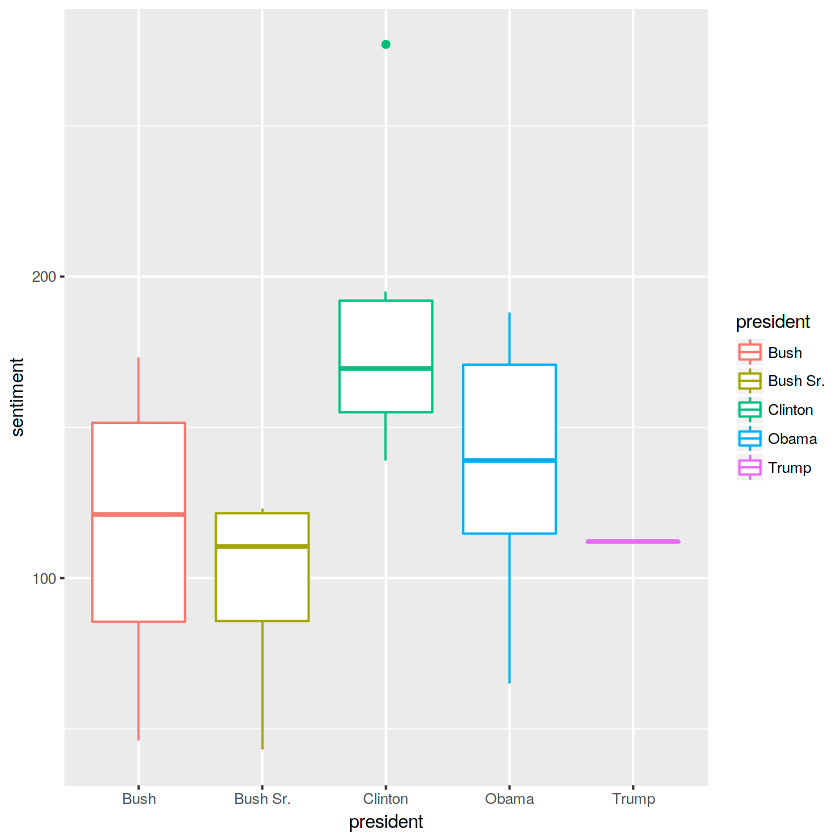

In [7]:
# plot of sentiment by president
ggplot(sentiments, aes(x = president, y = sentiment, color = president)) + 
  geom_boxplot() # draw a boxplot for each president

It looks like this is a pretty strong pattern. Let's directly compare the two parties to see if there's a reliable difference between them. We'll need to manually label which presidents were Democratic and which were Republican and then test to see if there's a difference in their sentiment scores.

Warning message in president == c("Clinton", "Obama"):
“longer object length is not a multiple of shorter object length”Joining, by = c("negative", "positive", "sentiment", "file", "year", "president", "party")



	Welch Two Sample t-test

data:  democrats$sentiment and republicans$sentiment
t = 2.2442, df = 16.606, p-value = 0.03876
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  2.256549 75.320374
sample estimates:
mean of x mean of y 
 149.2500  110.4615 


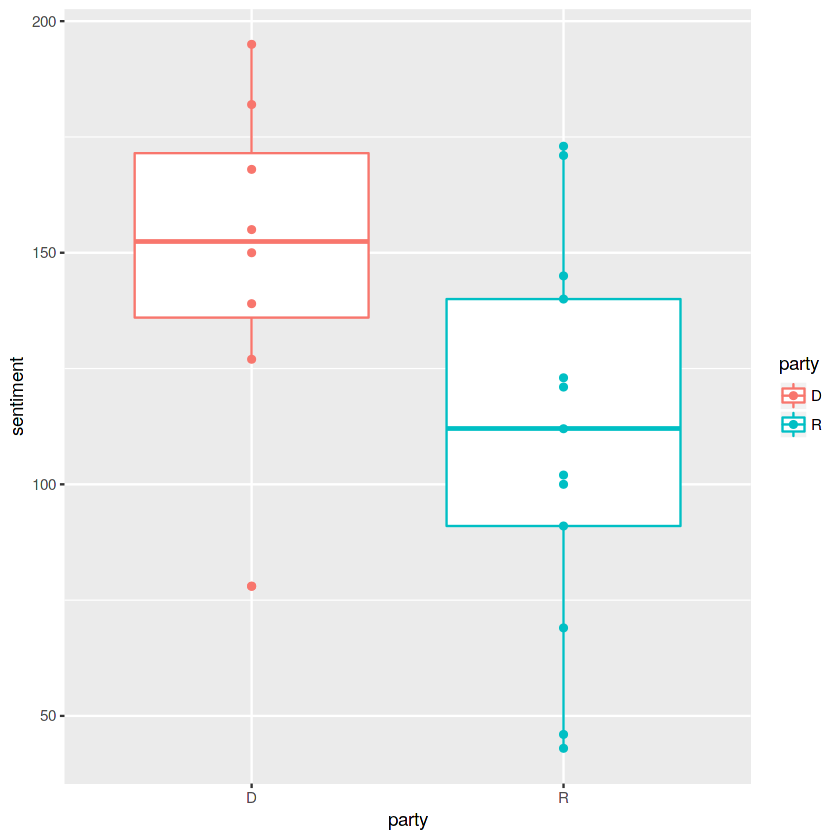

In [8]:
# is the difference between parties significant?
# get democratic presidents & add party affiliation
democrats <- sentiments %>%
    filter(president == c("Clinton","Obama")) %>%
    mutate(party = "D")

# get democratic presidents & party add affiliation
republicans <- sentiments %>%
    filter(president != "Clinton" & president != "Obama") %>%
    mutate(party = "R")

# join both
byParty <- full_join(democrats, republicans)

# the difference between the parties is significant
t.test(democrats$sentiment, republicans$sentiment)

# plot sentiment by party
ggplot(byParty, aes(x = party, y = sentiment, color = party)) + geom_boxplot() + geom_point()

So it looks like there is a reliable difference in the sentiment of the State of the Union addresses given by Democratic and Republican presidents, at least from 1989 to 2017. 

There a couple things to keep in mind with this analysis, though: 

* We didn't correct for the length of the documents. It could be that the State of the Union addresses from Democratic presidents have more positive words becuase they are longer rather than becuase they are more positive.
* We're using a general-purpose list of words rather than one specifically designed for analyzing political language. Furthermore, we only used one sentiment analysis list. 

With these two things in mind, I've written a couple of exercises for you. You can fork this notebook and continue working in the code chunks below.

# Exercises

Now that you're familiar with the basics of sentiment analysis, it's time for you to try your hand at it yourself! These exercises have been designed to get progressively more difficult, so I'd recommend completing them in order.

### Exercise 1: Normalizing for text length

In [9]:
# Rewrite the function GetSentiment so that it also returns the sentiment score
# divided by the number of words in each document.

# hint: you can use the function nrow() on your tokenized data_frame to find 
# the number of tokens in each document

# How does normalizing for text length change the outcome of the analysis?

### Exercise 2: Using a different sentiment lexicon


In [10]:
# The get_sentiments function has a number of different sentiment lexicons
# included in it. Repeat the analysis above with the "afinn" lexicon
# instead of the "bing" lexicon. (You can learnd about the "afinn" lexicon
# here: http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6010).
# Note that the "afinn" lexicon uses a scale for annotation. +5 is very 
# positive, while -5 is very negative.

# Does using a different lexicon result in a different outcome for your
# analysis? What does this suggest about the original analysis?

### Exercise 3: Creating your own sentiment lexicon

In [11]:
# Below, I've gotten a list of the 50 most frequent words in this corpus 
# (removing very common words like "and" or "the") that aren't also in the 
# "bing" lexicon. Can you tag these words for their sentiment, either positive,
# negative or neutral, and then use them to augment the "bing" sentiment lexicon?

# hint: you may find it easiest to upload your annotated list as a separate
# dataset and add it to the kernel.

# How does this affect your analysis? Do you think it would have had a different 
# effect if you had annotated 500 words instead? 50,000? Would your new lexicon
# be helpful in analyzing product reviews? Tweets?

In [12]:
# in this code block, we're getting a list of the 100 most frequent words in this
# corpus that 1) aren't stop words and 2) aren't already in the Bing lexicon

# function to get tokens from a file
fileToTokens <- function(file){
    # get the file
    fileName <- glue("../input/", file, sep = "")
    # get rid of any sneaky trailing spaces
    fileName <- trimws(fileName)

    # read in the new file
    fileText <- glue(read_file(fileName))
    # remove any dollar signs (they're special characters in R)
    fileText <- gsub("\\$", "", fileText) 

    # tokenize
    tokens <- data_frame(text = fileText) %>% unnest_tokens(word, text)
}

# empty data_frame to save our data in
allTokens <- NULL

# get the tokens in each file
for(i in files){
    allTokens <- rbind(allTokens, fileToTokens(i))
}

# get words already in the Bing sentiment dictionary
bingWords <- get_sentiments("bing")[,1]

# get the top 100 most frequent words, excluding stop words
# and word already in the "bing" lexicon
top100Words <- allTokens %>% 
    anti_join(stop_words) %>% # remove stop words
    anti_join(bingWords) %>% # remove words in the bing lexicon
    count(word, sort = T) %>% # sort by frequency
    top_n(100) # get the top 100 terms

# Save out the file (it will show up under "output") so you can download it
# and annotate it in a different program (if you like)
write.csv(top100Words, "top100Words.csv")

Joining, by = "word"
Joining, by = "word"
Selecting by n


### Exercise 4: Analyzing a new dataset

Now that you've got the skills to do sentiment analyis, it's time to apply them to a new dataset. You can find a list of text corpora already on Kaggle [here](https://www.kaggle.com/datasets?sortBy=updated&group=featured&search=corpus), but I've also selected a couple that I think would lend themselves well to sentiment analysis. I've also included some links to other sentiment lexicons you can find on Kaggle. Many are even for low-resource languages!

#### Text Corpora on Kaggle:

* [Eurovision YouTube Comments: YouTube comments on entries from the 2003-2008 Eurovision Song Contests](https://www.kaggle.com/rtatman/eurovision-youtube-comments)
* [UN General Debates:Transcriptions of general debates at the UN from 1970 to 2016](https://www.kaggle.com/unitednations/un-general-debates)
* [State of the Nation Corpus (1990 - 2017): Full texts of the South African State of the Nation addresses](https://www.kaggle.com/allank/state-of-the-nation-1990-2017)
* [A Million News Headlines: News headlines published over a period of 14 years.](https://www.kaggle.com/therohk/million-headlines)
* [SCOTUS Opinions Corpus: Lots of Big, Important Words](https://www.kaggle.com/jboysen/scotus-corpus)
* [Old Newspapers: A cleaned subset of HC Corpora newspapers](https://www.kaggle.com/alvations/old-newspapers)
* [Ubuntu Dialogue Corpus: 26 million turns from natural two-person dialogues](https://www.kaggle.com/rtatman/ubuntu-dialogue-corpus)
* [Fraudulent E-mail Corpus: CLAIR collection of "Nigerian" fraud emails](https://www.kaggle.com/rtatman/fraudulent-email-corpus)
* [Ironic Corpus: 1950 sentences labeled for ironic conten](https://www.kaggle.com/rtatman/ironic-corpus)

#### Additional Lexicons:

* [Sentiment Lexicons for 81 Languages: Sentiment Polarity Lexicons (Positive vs. Negative)](https://www.kaggle.com/rtatman/sentiment-lexicons-for-81-languages)
* [SentiWordNet: Sentiment WordNet Project](https://www.kaggle.com/nltkdata/sentiwordnet)
* [Thai Sentiment Analysis Toolkit: Positive, negative and swear words in Thai](https://www.kaggle.com/rtatman/thai-sentiment-analysis-toolkit)
* [German Sentiment Analysis Toolkit: 3468 German words sorted by sentiment](https://www.kaggle.com/rtatman/german-sentiment-analysis-toolkit)
* [Vader Lexicon: Lexicon use for the Vader Sentiment Algorithm](https://www.kaggle.com/nltkdata/vader-lexicon)
* [Opinion Lexicon: For Sentiment Analysis](https://www.kaggle.com/nltkdata/opinion-lexicon)
* [VerbNet: VerbNet Lexicon, Version 2.1](https://www.kaggle.com/nltkdata/verbnet)

Good luck and have fun! :)